# **Part 1**

Rendering environment

Kindly refer python file.

"We certify that the code and data in this assignment were generated independently, using only
the tools and resources defined in the course and that we did not receive any external help,
coaching or contributions during the production of this work."


In [ ]:
'''
import gym 

env=gym.make("CartPole-v1")

env.reset()

for i in range(200):
    env.render()
    env.step(env.action_space.sample())
    
env.close()

mountain_car=gym.make("MountainCar-v0")
mountain_car.reset()

for i in range(500):
    mountain_car.render()
    mountain_car.step(mountain_car.action_space.sample())

mountain_car.close()
'''

# **DQN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import random
from collections import deque
import torch
import torch.nn as nn
from gym import spaces
import matplotlib.pyplot as plt

In [ ]:
class GridEnvironment(gym.Env):

    def __init__(self, maxTimesteps = 20, rows = 4, cols = 4, stochastic = False):
        #grid should be square for generalization
        self.rows = rows
        self.cols = cols
        self.observation_space = spaces.Discrete(self.rows*self.cols)
        self.actions = {"UP":0, "RIGHT":1, "DOWN":2,"LEFT":3}
        self.action_space = spaces.Discrete(len(self.actions))
        self.maxTimesteps = maxTimesteps
        self.state = np.zeros((self.rows, self.cols))
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.rows-1, self.cols-1]
        self.trap_pos = [1,1]
        self.bonus_pos = [0,3]
        self.reward = {tuple(self.goal_pos): 2, tuple(self.trap_pos) : -1, tuple(self.bonus_pos): 1}
        self.rewardStates = {tuple(self.goal_pos), tuple(self.trap_pos), tuple(self.bonus_pos)}
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.stochastic = stochastic
        self.cumulativeReward = 0
        self.done = False
    
    def reset(self):
        self.state = np.zeros((self.rows, self.cols))
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.state[tuple(self.agent_pos)] = 2
        self.cumulativeReward = 0
        self.timestep = 0
        self.bonus_pos = [0,3]
        self.agent_pos = [0, 0]
        self.goal_pos = [self.rows-1, self.cols-1]
        self.trap_pos = [1,1]
        observation = self.agent_pos
        return observation
    
    def render(self):
        plt.imshow(self.state)
    
    def step(self, action):
    #adding stochasticity using random function
        sign = 1
        if self.stochastic:
            if np.random.random(1)[0] < 0.2:
                sign  = -1
        if action == 0:
            self.agent_pos[0] -= sign*1
        elif action == 1:
            self.agent_pos[1] += sign*1
        elif action == 2:
            self.agent_pos[0] += sign*1
        elif action == 3:
            self.agent_pos[1] -= sign*1

        if self.agent_pos[0]<0:
            self.agent_pos[0] = 0
        elif self.agent_pos[1] < 0:
            self.agent_pos[1] = 0
        elif self.agent_pos[0] >= self.rows:
            self.agent_pos[0] = self.rows-1
        elif self.agent_pos[1] >= self.cols:
            self.agent_pos[1] = self.cols-1
        #print("agent: ", self.agent_pos)
        #self.agent_pos = np.clip(self.agent_pos, 0, self.rows-1)

        self.state = np.zeros((self.rows, self.cols))
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.state[tuple(self.agent_pos)] = 2
        observation = self.agent_pos
        self.timestep += 1
        r = 0
        if self.timestep >= self.maxTimesteps  and not (self.goal_pos[0]==self.agent_pos[0] and self.goal_pos[1]==self.agent_pos[1]):
            r = -4
        done = True if (self.timestep >= self.maxTimesteps or (self.goal_pos[0]==self.agent_pos[0] and self.goal_pos[1]==self.agent_pos[1])) else False
        r+=self.getReward(self.agent_pos)
        self.cumulativeReward+=r
        info = {}

        return observation, r, done, info

    def getReward(self,pos):
        if tuple(pos) not in self.rewardStates:
            return -0.1
        else:
            return self.reward[tuple(pos)]

In [ ]:
class NeuralLayer(nn.Module):
    def __init__(self, ):
        super(NeuralLayer, self).__init__()
        #neural layer 1 - linear layer
        self.nnlayer1 = nn.Linear(2, 32)
        #normalizing weights of layer1
        self.nnlayer1.weight.data.normal_(0, 0.1)

        # final output 1-d size 4 vector
        self.nnlayer2 = nn.Linear(32, 4)
        #normalizing weights of layer2
        self.nnlayer2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.nnlayer1(x)
        x = F.relu(x)
        x = self.nnlayer2(x)
        return x

In [ ]:
class DQNModel:
    def __init__(self, env, maxReplayBufferSize = 1200, minBatchSize=50, batchSize=50, epsilon=1, epsilonDecay=0.99, update=100, gamma=0.9):
        self.maxBufferSize=maxReplayBufferSize
        self.minBatchSize=minBatchSize
        self.batchSize=batchSize
        self.epsilon=epsilon
        self.update=update
        self.gamma=gamma
        self.replay_memory = deque(maxlen = maxReplayBufferSize)
        self.model = NeuralLayer()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.learn_counter = 0
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.env = env
        self.target_model = NeuralLayer()
        self.target_model.nnlayer1.weight = self.model.nnlayer1.weight
        self.target_model.nnlayer2.weight = self.model.nnlayer2.weight
        self.epsilonDecay=epsilonDecay

    def step(self, agent_pos):
        agent_pos = Variable(torch.unsqueeze(torch.FloatTensor(agent_pos), 0))
        if np.random.uniform() > self.epsilon:
          actions = self.model(agent_pos)
          agent_pos = torch.max(actions, 1)[1].data.numpy()
          agent_pos = agent_pos[0]
        else:
          agent_pos = np.random.randint(4)
        return agent_pos
        
    def store_mem(self, state, action, reward, next_state, done):
        #creating replay buffer
        self.replay_memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_memory) < self.minBatchSize:
          return

        if self.learn_counter % self.update == 0:
            self.target_model.nnlayer1.weight = self.model.nnlayer1.weight
            self.target_model.nnlayer2.weight = self.model.nnlayer2.weight

        batch = random.sample(self.replay_memory, self.batchSize)
        batchObservations = zip(*batch)
        state1, action, reward, state2, done =  list(batchObservations)
        state1 = torch.FloatTensor(state1)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward).view(self.batchSize,1)
        state2 = torch.FloatTensor(state2)
        q_val = self.model(state1)
        next_q_value = self.target_model(state2)  

        q_target = torch.tensor([next_q_value[i].max()*self.gamma+reward[i] for i in range(self.batchSize)])
        q_temp = q_val[:, 0]
        for i in range(len(done)):
          q_temp[i] = q_val[i][action[i]]
          if done[i]:
            q_target[i] = reward[i]
                    
        q_target = torch.FloatTensor(q_target)

        loss = self.loss_func(q_temp, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.learn_counter += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


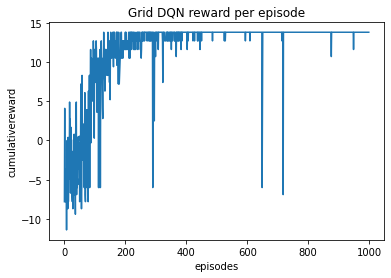

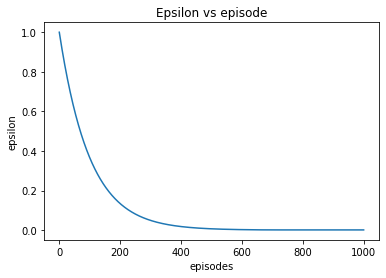

In [ ]:
#DQN model
env = GridEnvironment()
agent = DQNModel(env)

obs = env.reset()
done = False

gridDQNplot=[]
epsilonArr = [agent.epsilon]

#DQN run
for i in range(1000):
    state = env.reset()
    encodedstate=np.array(range(0,16)).reshape(4,4)
    done = False
    cumulative_reward=0
    env.ate = False
    for k in range(env.maxTimesteps):
      action = agent.step(env.agent_pos)
      s = np.copy(env.agent_pos)
      obs, reward, done, info = env.step(action)
      s_ = np.copy(obs)
      agent.store_mem(s, action, reward, s_, done)
      cumulative_reward=env.cumulativeReward
      # trains for every 3 time steps
      if k%3 == 0:
        agent.train()
      if done: 
        break
    if agent.epsilon>=0.001:
      agent.epsilon*=agent.epsilonDecay
    epsilonArr.append(agent.epsilon)
    gridDQNplot.append(cumulative_reward)

plt.plot(gridDQNplot)
plt.title('Grid DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(epsilonArr)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()

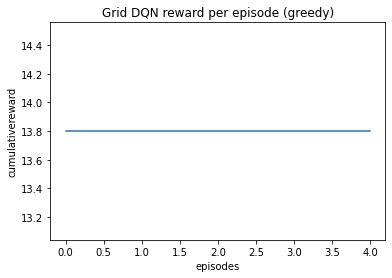

In [ ]:
gridDDQNgreedy = []
for i in range(5):
    state = env.reset()
    done = False
    cumulative_reward=0
    env.ate = False
    for _ in range(env.maxTimesteps):
      action = agent.step(env.agent_pos)
      obs, reward, done, info = env.step(action)
      cumulative_reward+=reward
      if done: 
        break
    if agent.epsilon>=0.01:
      agent.epsilon*=agent.epsilonDecay
    gridDDQNgreedy.append(cumulative_reward)
plt.plot(gridDDQNgreedy)
plt.title('Grid DQN reward per episode (greedy)')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

# **Double DQN**

In [ ]:
class DoubleDQNModel:
    def __init__(self, env, maxReplayBufferSize = 1200, minBatchSize=50, batchSize=50, epsilon=1, epsilonDecay=0.99, update=100, gamma=0.9):
        self.maxBufferSize=maxReplayBufferSize
        self.minBatchSize=minBatchSize
        self.batchSize=batchSize
        self.epsilon=epsilon
        self.update=update
        self.gamma=gamma
        self.replay_memory = deque(maxlen = maxReplayBufferSize)
        self.model = NeuralLayer()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.learn_counter = 0
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.env = env
        self.target_model = NeuralLayer()
        self.target_model.nnlayer1.weight = self.model.nnlayer1.weight
        self.target_model.nnlayer2.weight = self.model.nnlayer2.weight
        self.epsilonDecay=epsilonDecay

    def step(self, agent_pos):
        agent_pos = Variable(torch.unsqueeze(torch.FloatTensor(agent_pos), 0))
        if np.random.uniform() > self.epsilon:
          actions = self.model(agent_pos)
          agent_pos = torch.max(actions, 1)[1].data.numpy()
          agent_pos = agent_pos[0]
        else:
          agent_pos = np.random.randint(4)
        return agent_pos
        
    def store_mem(self, state, action, reward, next_state, done):
        #creating replay buffer
        self.replay_memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_memory) < self.minBatchSize:
          return

        if self.learn_counter % self.update == 0:
            self.target_model.nnlayer1.weight = self.model.nnlayer1.weight
            self.target_model.nnlayer2.weight = self.model.nnlayer2.weight

        batch = random.sample(self.replay_memory, self.batchSize)
        batchObservations = zip(*batch)
        state1, action, reward, state2, done =  list(batchObservations)
        state1 = torch.FloatTensor(state1)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward).view(self.batchSize,1)
        state2 = torch.FloatTensor(state2)
        
        q_val = self.model(state2)
        next_q_value = self.target_model(state2)  
        
        q_args = torch.tensor([torch.argmax(next_q_value[i]) for i in range(self.batchSize)])
        q_temp = q_val[:, 0]
        for i in range(self.batchSize):
          q_temp[i] = q_val[i][q_args[i]]
        q_temp = q_temp.view(self.batchSize, 1)
        q_target = reward+self.gamma*q_temp
        
        q_val = self.model(state1)
        q_temp = q_val[:, 0]
        for i in range(self.batchSize):
          q_temp[i] = q_val[i][action[i]]
        q_temp = q_temp.view(self.batchSize,1)

        loss = self.loss_func(q_temp, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.learn_counter += 1

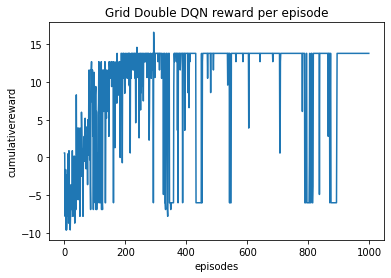

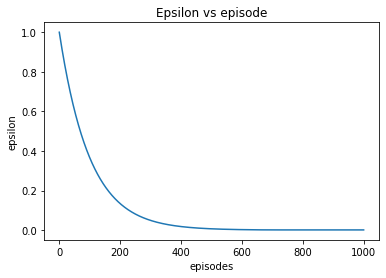

In [ ]:
#Double DQN model
env = GridEnvironment()
agent = DoubleDQNModel(env)

obs = env.reset()
done = False

gridDDQNplot=[]
n_games = 1000
epsilonArr = [agent.epsilon]

#DQN run
for i in range(n_games):
    state = env.reset()
    encodedstate=np.array(range(0,16)).reshape(4,4)
    done = False
    cumulative_reward=0
    env.ate = False
    for k in range(env.maxTimesteps):
      action = agent.step(env.agent_pos)
      s = np.copy(env.agent_pos)
      obs, reward, done, info = env.step(action)
      s_ = np.copy(obs)
      agent.store_mem(s, action, reward, s_, done)
      cumulative_reward=env.cumulativeReward
      # trains for every 3 time steps
      if k%3 == 0:
        agent.train()
      if done: 
        break
    if agent.epsilon>=0.001:
      agent.epsilon*=agent.epsilonDecay
    epsilonArr.append(agent.epsilon)
    gridDDQNplot.append(cumulative_reward)

plt.plot(gridDDQNplot)
plt.title('Grid Double DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(epsilonArr)
plt.title('Epsilon vs episode')
plt.xlabel('episodes')
plt.ylabel('epsilon')
plt.show()



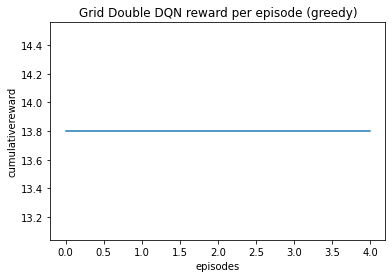

In [ ]:
gridDDQNgreedy = []
for i in range(5):
    state = env.reset()
    done = False
    cumulative_reward=0
    env.ate = False
    for _ in range(env.maxTimesteps):
      action = agent.step(env.agent_pos)
      obs, reward, done, info = env.step(action)
      cumulative_reward+=reward
      if done: 
        break
    # EPSILON = EPSILON - 2/n_games if EPSILON > 0.01 else 0.01
    if agent.epsilon>=0.01:
      agent.epsilon*=agent.epsilonDecay
    gridDDQNgreedy.append(cumulative_reward)
plt.plot(gridDDQNgreedy)
plt.title('Grid Double DQN reward per episode (greedy)')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

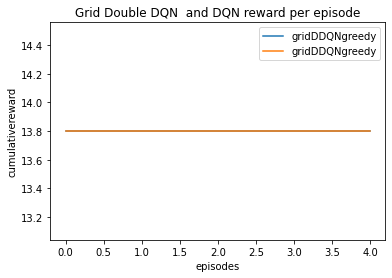

In [ ]:
plt.plot(gridDDQNgreedy, label="gridDDQNgreedy")
plt.plot(gridDQNgreedy, label="gridDQNgreedy")
plt.title('Grid Double DQN  and DQN reward per episode')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.legend(loc='best')
plt.show()

# **CartPole-v1**

In [ ]:
computeUnit = torch.device("cpu")

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.loss = nn.MSELoss()
        self.to(computeUnit)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
env = gym.make('CartPole-v1').unwrapped
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

computeUnit = torch.device("cpu")

class ReplayBuffer:
    def __init__(self, size=10000, batchSize=64):
        self.mem_count = 0
        self.memSize=size
        self.batchSize=batchSize
        self.states = np.zeros((self.memSize, *env.observation_space.shape),dtype=np.float32)
        self.states2 = np.zeros((self.memSize, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(self.memSize, dtype=np.int64)
        self.dones = np.zeros(self.memSize, dtype=np.bool)
        self.rewards = np.zeros(self.memSize, dtype=np.float32)

    
    def add(self, state, action, reward, state2, done):
        idx = self.mem_count % self.memSize
        self.states[idx]  = state
        self.states2[idx] = state2
        self.rewards[idx] = reward
        self.actions[idx] = action
        self.dones[idx] =  1 - done
        self.mem_count += 1
    
    def sample(self):
        maxMem = min(self.mem_count, self.memSize)
        idx = np.random.choice(maxMem, self.batchSize, replace=True)
        states  = self.states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        states2 = self.states2[idx]
        dones   = self.dones[idx]
        return states, actions, rewards, states2, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.epsilon = 1
        self.epsilonDecay=0.99
        self.learn_step_counter = 0
        self.net_copy_interval = 10
        self.model = Network()
        self.model_target = Network()
        self.batchSize=64
        self.gamma=0.95
        self.memory_counter = 0

    def choose_action(self, observation):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        
        state = torch.tensor(observation).float().detach()
        state = state.to(computeUnit)
        state = state.unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def buffer(self, state, action, reward, state2):
        tmp = np.hstack((state, [action, reward], state2))
        index = self.memory_counter % self.memory.memSize
        self.replay_mem[index, :] = tmp
        self.memory_counter += 1  

    def learn(self):
        if self.memory.mem_count < self.batchSize:
            return
        
        states, actions, rewards, states2, dones = self.memory.sample()

        states = torch.tensor(states , dtype=torch.float32).to(computeUnit)
        states2 = torch.tensor(states2, dtype=torch.float32).to(computeUnit)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(computeUnit)
        actions = torch.tensor(actions, dtype=torch.long).to(computeUnit)
        dones = torch.tensor(dones, dtype=torch.bool).to(computeUnit)

        idx = np.arange(self.batchSize, dtype=np.int64)

        q_values = self.model(states)[idx, actions] 
        next_q_values = self.model_target(states2)
        actions_ = self.model(states2).max(dim=1)[1]
        actions_ = next_q_values[idx, actions_]

        q_target = rewards + self.gamma * actions_ * dones
        td = q_target - q_values

        self.model.optimizer.zero_grad()
        loss = ((td ** 2.0)).mean()
        loss.backward()
        self.model.optimizer.step()

        if self.epsilon>0.001:
            self.epsilon *= self.epsilonDecay

        if self.learn_step_counter % self.net_copy_interval == 0:
            self.model_target.load_state_dict(self.model.state_dict())

        self.learn_step_counter += 1
    
agent = DQN_Solver()
best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, 100):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {}".format(i, average_reward/i, best_reward, score))
            average_reward += score 
            break
            
        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.title('cartpole DQN average reward per ep')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()